# AMSC698K Homework 4
##### Elijah Kin & Noorain Noorani

In [1]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import numpy as np


print(qiskit.__version__)

1.2.4


## General Grover's Algorithm Code

In [ ]:
def diffuser(q, label='diffuser'):    
    qc = QuantumCircuit(q)         
    n = qc.num_qubits   
    qc.h([q[i] for i in range(n-1)])
    qc.x([ q[i] for i in range(n-1) ])         
    if n > 2:
        # for multi-controlled Z use multi-controlled Z rotation
        qc.mcrz(np.pi, q[0:n-2], q[n-2])
    else:
        # for one-qubit oracles no controls
        qc.z(q[0])
    qc.barrier()
    qc.x([ q[i] for i in range(n-1) ])
    qc.h([ q[i] for i in range(n-1) ])    
    return qc

In [43]:
def grover(var_qubits, clause_qubits, output_qubits, cbits, oracle, iterations=1, measure=True):
    var_qubits = QuantumRegister(var_qubits, name='v')
    clause_qubits = QuantumRegister(clause_qubits, name='c')
    output_qubit = QuantumRegister(output_qubits, name='out')
    cbits = ClassicalRegister(cbits, name='cbits')

    if measure:
        qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)
    else:
        qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit)

    # Initialize 'out0' in state |->
    qc.x(output_qubit)
    qc.h(output_qubit)

    # Initialize qubits in state |s>
    qc.h(var_qubits) 
    qc.barrier()  # for visual separation

    # add repetitions of oracle plus diffusion operator
    for i in range(iterations):  
        # qc.compose(oracle(qc, var_qubits, clause_qubits, output_qubit), [0,1,2,3,4,5,6,7,8,9,10], inplace=True)
        oracle(qc, var_qubits, clause_qubits, output_qubit)
        qc.barrier()
        # qc.compose(diffuser(var_qubits), [0,1,2,3,4], inplace=True)
        qc.compose(diffuser(var_qubits), list(range(0,var_qubits.size)), inplace=True)
        qc.save_statevector(label=f"diffuser_{i}")

    if(measure):
        qc.measure(var_qubits, cbits)

    return qc

### 1. Use Grover's algorithm (or Amplitude Amplification (QAA)) to solve these problems:

A. Alice, Bob, Charlie, Dora want to set up a meeting. Alice can only meet on Monday, Tuesday, or Thursday; Bob cannot meet on Wednesday; Charlie cannot meet on Thursday, Dora cannot meet on Tuesday nor Friday. Find the day they can meet using Grover's algorithm.

In [44]:
def Scheduling_Oracle(circ, vq, cq, output_qubit):
    # Alice's avialble time slots
    circ.barrier(label="Alice")
    circ.x([vq[0], vq[1], vq[3]])
    circ.x(cq[0])
    circ.mcx([vq[0], vq[1], vq[3]], cq[0]) # Available
    circ.x([vq[0], vq[1], vq[3]])
    
    # Bob's avialble time slots
    circ.barrier(label="Bob")
    circ.x(vq[2])
    circ.mcx([vq[2]], cq[1]) 
    circ.x(vq[2])

    # Charlie's avialble time slots
    circ.barrier(label="Charlie")
    circ.x(vq[3])
    circ.mcx([vq[3]], cq[2])
    circ.x(vq[3])

    # Dora's avialble time slots
    circ.barrier(label="Dora")
    circ.x(vq[1])
    circ.mcx([vq[1]], cq[3])
    circ.x(vq[1])
    circ.x(vq[4])
    circ.mcx([vq[4]], cq[4])
    circ.x(vq[4])

    circ.barrier(label="Combining Ancilla Things")
    # Putting together for output
    circ.mcx([cq[0], cq[1], cq[2], cq[3], cq[4]], output_qubit[0])

    ## Uncompute
    # Uncompute Dora's avialble time slots
    circ.barrier(label="Uncompute Dora")
    circ.x(vq[4])
    circ.mcx([vq[4]], cq[4])
    circ.x(vq[4])
    circ.x(vq[1])
    circ.mcx([vq[1]], cq[3])
    circ.x(vq[1])
    
    # UncomputeCharlie's avialble time slots
    circ.barrier(label="Uncompute Charlie")
    circ.x(vq[3])
    circ.mcx([vq[3]], cq[2])
    circ.x(vq[3])

    # Uncompute Bob's avialble time slots
    circ.barrier(label="Uncompute Bob")
    circ.x(vq[2])
    circ.mcx([vq[2]], cq[1]) 
    circ.x(vq[2])
    
    # Uncompute Alice's avialble time slots
    circ.barrier(label="Uncomputer Alice")
    circ.x([vq[0], vq[1], vq[3]])
    circ.mcx([vq[0], vq[1], vq[3]], cq[0]) # Available
    circ.x([vq[0], vq[1], vq[3]])
    circ.x(cq[0])

    circ.barrier()

    return circ

To determine the number of iterations to run Grover's Algorithm we refer to equation:

$$t = \frac{\pi}{4} \sqrt{N}$$

Where N is the possible solution states, $2^n$, where n are the qubits of the input

In this case we have 5 qubits, $N = 32$ , so $ t \approx 1$

In [45]:
var_qubits = QuantumRegister(5, name='v')
clause_qubits = QuantumRegister(5, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(5, name='cbits')

qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

oracle = Scheduling_Oracle(qc, var_qubits, clause_qubits, output_qubit)
# oracle.barrier()
# oracle.draw(output='mpl')

In [47]:
circ_groverA = grover(var_qubits = 5, 
                      clause_qubits = 5, 
                      output_qubits = 1, 
                      cbits = 5, 
                      oracle = Scheduling_Oracle, 
                      iterations=1, 
                      measure=True)

# circ_groverA.draw(output = 'mpl', plot_barriers=True)

{'01100': 13, '01110': 23, '10011': 30, '10010': 31, '11110': 24, '01101': 16, '10111': 28, '01011': 16, '00101': 29, '10101': 30, '00010': 32, '11001': 33, '10000': 27, '00110': 40, '11101': 33, '01010': 20, '11100': 35, '01111': 14, '10100': 35, '00111': 31, '00001': 128, '11010': 28, '01000': 21, '10001': 28, '00011': 30, '00100': 34, '01001': 17, '11011': 38, '00000': 40, '10110': 27, '11111': 28, '11000': 41}


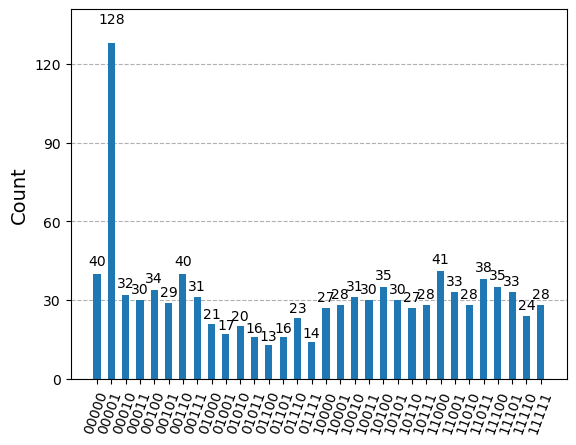

In [48]:
backend_aer = Aer.get_backend('qasm_simulator')
counts = backend_aer.run(circ_groverA, shots=1000).result().get_counts()
print(counts)
plot_histogram(counts)

B. Alice and Bob work at the front desk of their company from Monday to Wednesday in 2 shifts; each shift is assigned to one employee. Write the constraints as logic expressions and use Grover's algorithm to see whether the shifts can be assigned to Alice and Bob (i) if Alice doesn't want to work more than 4 shifts at the front desk and Bob doesn't want to work on consecutive days at the front desk; (ii) Bob doesn't want to have the same shift on consecutive days and Alice prefers afternoon shifts; what if Alice doesn't want any morning shift?

(i) If Alice doesn't want to work more than 4 shifts at the front desk and Bob doesn't want to work on consecutive days at the front desk. We can write these constraints in conjuctive normal form where
- $x_{M,1}$ Alice working the morning shift on Monday
- $x_{M,2}$ Alice working the afternoon shift on Monday
- $x_{T,1}$ Alice working the morning shift on Tuesday
- $x_{T,2}$ Alice working the afternoon shift on Tuesday
- $x_{W,1}$ Alice working the morning shift on Wednesday
- $x_{W,2}$ Alice working the afternoon shift on Wednesday

We can then write the constraint of Alice not wanting to work more than 4 shifts as 6 clauses
- $\neg(x_{M,1} \land x_{M,2} \land x_{T,1} \land x_{T,2} \land x_{W,1})$
- $\neg(x_{M,1} \land x_{M,2} \land x_{T,1} \land x_{T,2} \land x_{W,2})$
- $\neg(x_{M,1} \land x_{M,2} \land x_{T,1} \ \land x_{W,1} \land x_{W,2})$
- $\neg(x_{M,1} \land x_{M,2} \land x_{T,2} \ \land x_{W,1} \land x_{W,2})$
- $\neg(x_{M,1} \land x_{T,1} \land x_{T,2} \ \land x_{W,1} \land x_{W,2})$
- $\neg(x_{M,2} \land x_{T,1} \land x_{T,2} \ \land x_{W,1} \land x_{W,2})$

If Bob doesn't want to work on consecutive days at the front desk we can write 8 clauses:

For Monday-Tuesday
- $\neg(x_{M,1} \land x_{T,1})$
- $\neg(x_{M,1} \land x_{T,2})$
- $\neg(x_{M,2} \land x_{T,1})$
- $\neg(x_{M,2} \land x_{T,2})$

For Tuesday-Wednesday
- $\neg(x_{T,1} \land x_{W,1})$
- $\neg(x_{T,1} \land x_{W,2})$
- $\neg(x_{T,2} \land x_{W,1})$
- $\neg(x_{T,2} \land x_{W,2})$

We can use this to create the orcale below

In [49]:
# TODO
def oracle_Bi(circ, vq, cq, output_qubit):
    circ.barrier(label="Alice not 4 shifts")
    circ.x([cq[0], cq[1], cq[2], cq[3], cq[4], cq[5]])
    circ.mcx([vq[0], vq[1], vq[2], vq[3], vq[4]], cq[0])
    circ.mcx([vq[0], vq[1], vq[2], vq[3], vq[5]], cq[1])
    circ.mcx([vq[0], vq[1], vq[2], vq[4], vq[5]], cq[2])
    circ.mcx([vq[0], vq[1], vq[3], vq[4], vq[5]], cq[3])
    circ.mcx([vq[0], vq[2], vq[3], vq[4], vq[5]], cq[4])
    circ.mcx([vq[1], vq[2], vq[3], vq[4], vq[5]], cq[5])

    circ.barrier(label="Bob consecutive shifts")
    circ.barrier(label="Monday-Tuesday")
    circ.x([cq[6], cq[7], cq[8], cq[9]])
    circ.mcx([vq[0], vq[2]], cq[6])
    circ.mcx([vq[0], vq[3]], cq[7])
    circ.mcx([vq[1], vq[2]], cq[8])
    circ.mcx([vq[1], vq[3]], cq[9])

    circ.barrier(label="Tuesday-Wednesday")
    circ.x([cq[10], cq[11], cq[12], cq[13]])
    circ.mcx([vq[2], vq[4]], cq[10])
    circ.mcx([vq[2], vq[5]], cq[11])
    circ.mcx([vq[3], vq[4]], cq[12])
    circ.mcx([vq[3], vq[5]], cq[13])

    circ.barrier(label="Combining Ancilla Things")
    circ.mcx([cq[0], cq[1], cq[2], cq[3], cq[4], cq[5], cq[6], cq[7], cq[8], cq[9], cq[10], cq[11], cq[12], cq[13]], output_qubit[0])

    ## Uncompute
    # Uncompute Bob consecutive shifts
    circ.barrier(label="Uncompute Bob")
    circ.barrier(label="Tuesday-Wednesday")
    circ.mcx([vq[3], vq[5]], cq[13])
    circ.mcx([vq[3], vq[4]], cq[12])
    circ.mcx([vq[2], vq[5]], cq[11])
    circ.mcx([vq[2], vq[4]], cq[10])
    circ.x([cq[10], cq[11], cq[12], cq[13]])

    circ.barrier(label="Monday-Tuesday")
    circ.mcx([vq[1], vq[3]], cq[9])
    circ.mcx([vq[1], vq[2]], cq[8])
    circ.mcx([vq[0], vq[3]], cq[7])
    circ.mcx([vq[0], vq[2]], cq[6])
    circ.x([cq[6], cq[7], cq[8], cq[9]])

    circ.barrier(label="Uncompute Alice not 4 shifts")
    circ.mcx([vq[1], vq[2], vq[3], vq[4], vq[5]], cq[5])
    circ.mcx([vq[0], vq[2], vq[3], vq[4], vq[5]], cq[4])
    circ.mcx([vq[0], vq[1], vq[3], vq[4], vq[5]], cq[3])
    circ.mcx([vq[0], vq[1], vq[2], vq[3], vq[5]], cq[2])
    circ.mcx([vq[0], vq[1], vq[2], vq[4], vq[5]], cq[1])
    circ.mcx([vq[0], vq[1], vq[2], vq[3], vq[4]], cq[0])
    circ.x([cq[0], cq[1], cq[2], cq[3], cq[4], cq[5]])

    return circ

# var_qubits = QuantumRegister(6, name='v')
# clause_qubits = QuantumRegister(14, name='c')
# output_qubit = QuantumRegister(1, name='out')
# cbits = ClassicalRegister(6, name='cbits')

# qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# oracle = oracle_Bi(qc, var_qubits, clause_qubits, output_qubit)
# # oracle.barrier()
# oracle.draw(output='mpl')

In [78]:
circ_groverBi = grover(var_qubits = 6, 
                      clause_qubits = 15, 
                      output_qubits = 1, 
                      cbits = 6, 
                      oracle = oracle_Bi, 
                      iterations=15, 
                      measure=True)

{'111011': 15, '011000': 7, '011110': 10, '001110': 6, '010101': 15, '110110': 14, '111101': 17, '111010': 14, '111100': 19, '001000': 22, '011111': 13, '101010': 18, '101100': 20, '100111': 16, '000110': 11, '010010': 41, '001111': 11, '110101': 11, '111111': 7, '000100': 25, '000001': 15, '100101': 16, '100010': 16, '101000': 17, '001100': 25, '111110': 18, '100000': 16, '111000': 15, '000010': 28, '110011': 12, '101101': 18, '001001': 10, '001011': 11, '011011': 10, '000011': 16, '101001': 10, '010100': 13, '000111': 5, '011010': 10, '110100': 13, '101110': 12, '110010': 19, '101011': 15, '010111': 9, '010110': 7, '010001': 35, '111001': 15, '100001': 14, '100110': 20, '010000': 36, '000101': 1, '011101': 9, '000000': 18, '110001': 17, '100100': 10, '001010': 6, '101111': 11, '011100': 12, '100011': 24, '011001': 6, '110111': 21, '010011': 39, '001101': 13, '110000': 25}


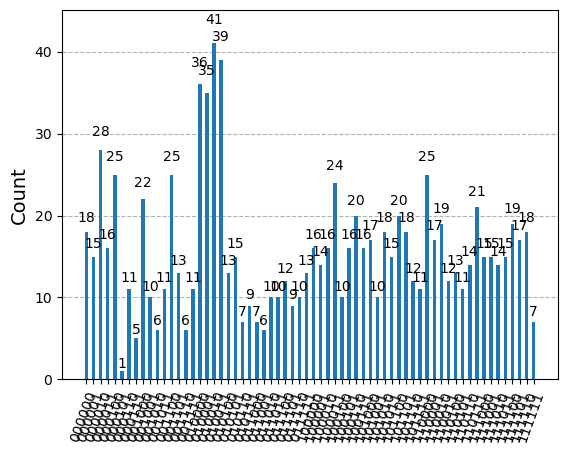

In [79]:
backend_aer = Aer.get_backend('qasm_simulator')
counts = backend_aer.run(circ_groverBi, shots=1000).result().get_counts()
print(counts)
plot_histogram(counts)

C. Consider a set of 24 marbles, some marbles are white colored and the rest black. Apply QAA to identify the white-colored marbles if 2, 3, 4, or 14 marbles are white-colored. How many sequences of QAA do you have to apply to find the marbles at less than 5% uncertainty.

In [ ]:
# TODO

### 2. Given the unsorted list [7,62,48,55,39,17,32,15,27,0,41,3,59,31,51,4].
Use Grover's algorithm (or QAA) to find the list indices of numbers 32, 3, and 27.

In [ ]:
# TODO
# Want to find 32, 3, and 27.
# Looking for the list indicides
N = 6 # for numbers up to 64

# create an oracle for each number in binary
def list_oracle(q, n = [32, 3, 27]):
    circ = QuantumCircuit(q)
    for i in range(len(n)):
        b = format(n[i], f'0{N}b')
        print(b)
        circ.barrier(label=f"{n[i]}")

        for j in range(N):
            if b[j] == '0':
                circ.x(q[j])

        circ.mcx(q[0:N], q[N + i])

        for j in range(N):
            if b[j] == '0':
                circ.x(q[j])
    return circ

100000
000011
011011


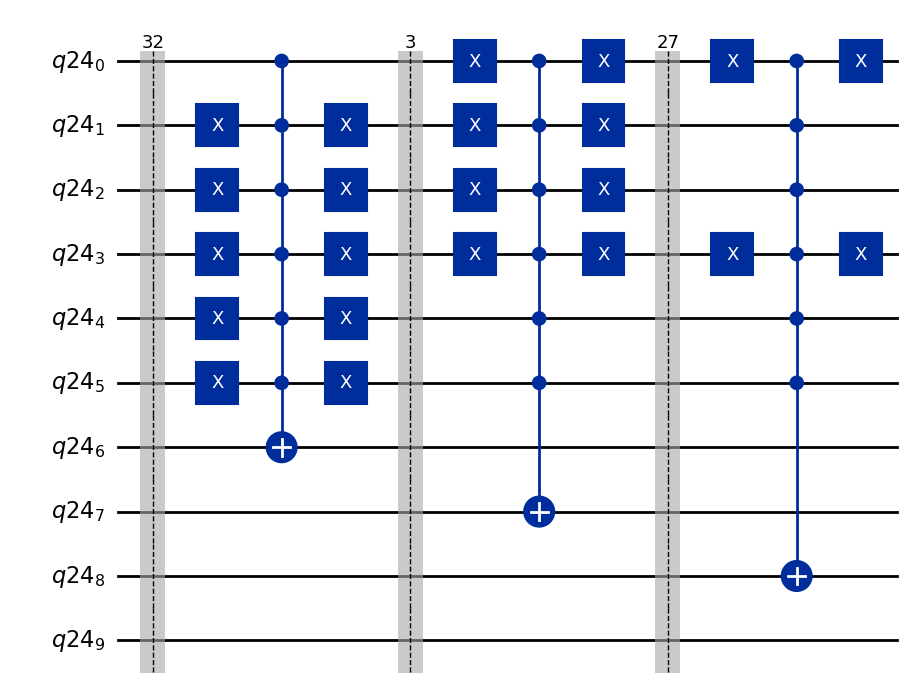

In [ ]:
oracle_list = QuantumRegister(10)
oracle_list = list_oracle(oracle_list)
oracle_list.draw(output = 'mpl', plot_barriers=True)